In [1]:
import h5py
import numpy as np
import pandas as pd
import math as math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.signal import savgol_filter
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
from PIL import Image as im

# specify data file
file_storage=r'C:\Users\PAM Group\Documents\Users\Takashi\test.h5'

# specify matplotlib configuration file
rc_fname = r'C:\Users\pam-admin\Documents\GitHub\spectroscopy\plotting_params.txt'

# useful functions
def find_nearest_val(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

# load file in correct format and find last dataset
f = h5py.File(file_storage, 'r')
ds_ids=list(f.keys())
last_ds_id=ds_ids[-1][8:]
print('Last dataset is '+str(last_ds_id))

Last dataset is 4


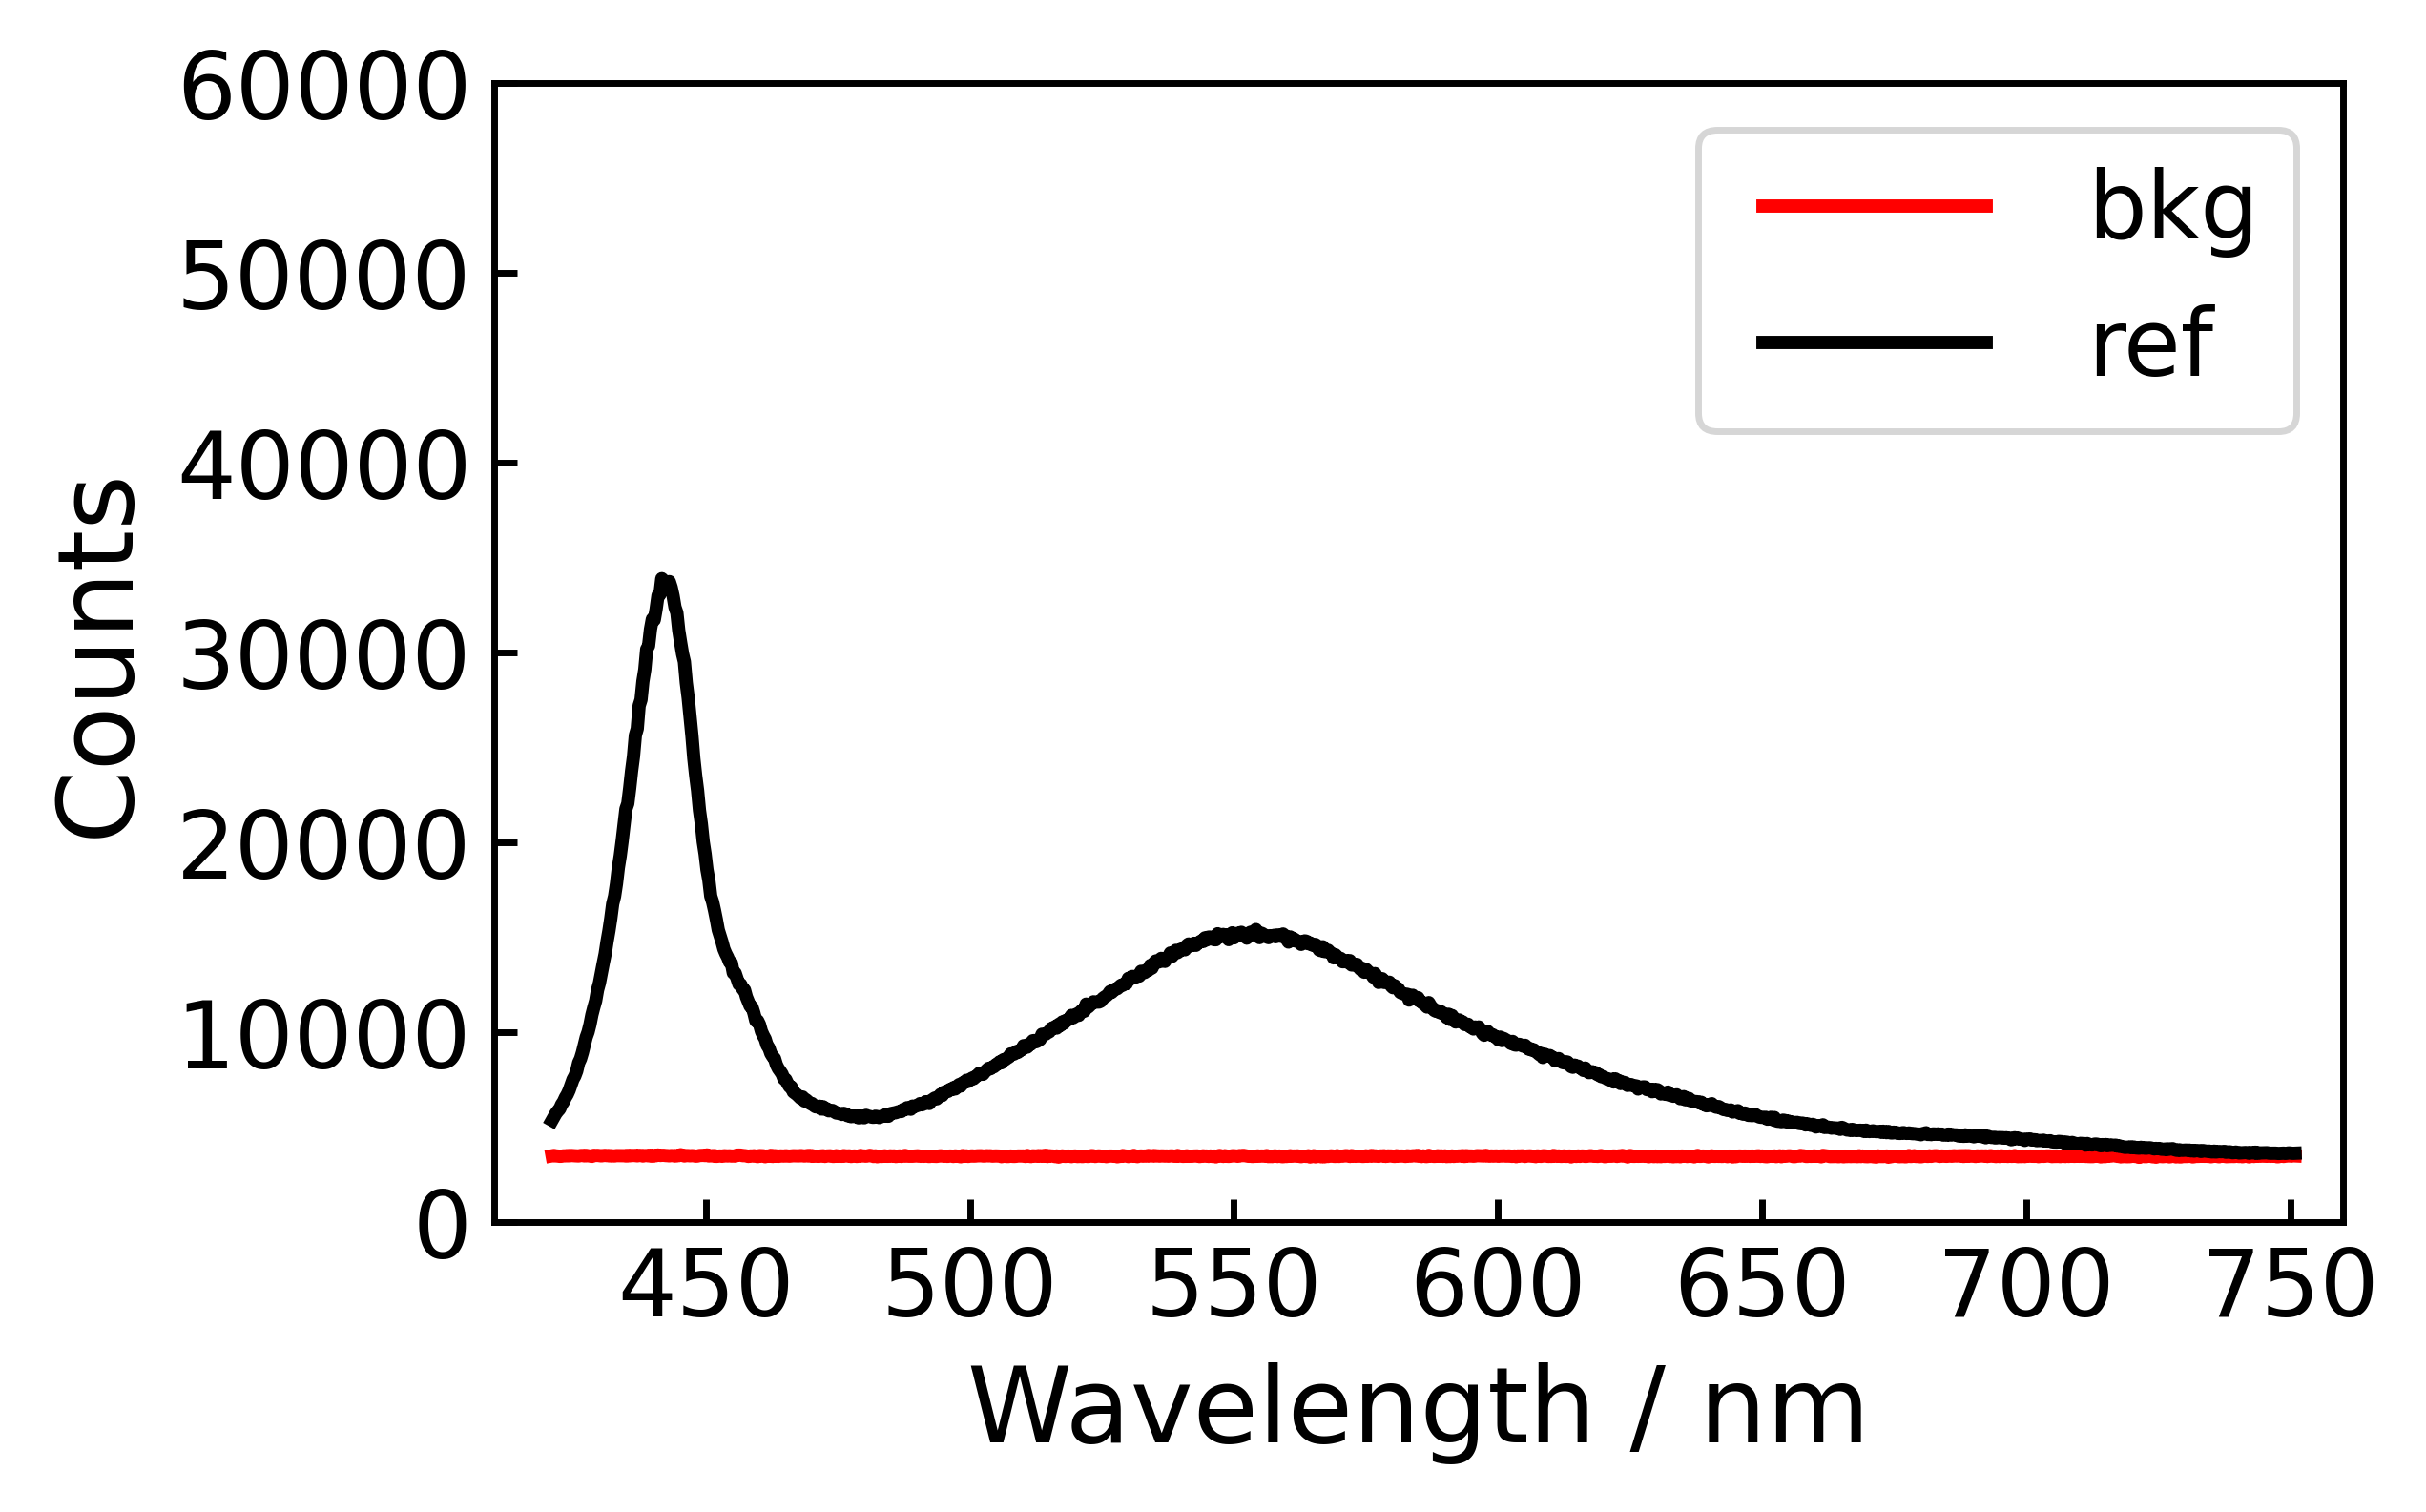

In [2]:
# check background and reference spectra
bkg=f['dataset_'+str(last_ds_id)]
bkg_i=bkg['image_'+str(last_ds_id)]
bkg_s=pd.Series(data=bkg['spec_'+str(last_ds_id)][1],index=bkg['spec_'+str(last_ds_id)][0])
bkg_s=bkg_s.truncate(before=420.8844873459128, after=750.9364930772199)
bkg_s[bkg_s < 0] = 0

ref=f['dataset_0']
ref_i=ref['image_0']
ref_s=pd.Series(data=ref['spec_0'][1],index=ref['spec_0'][0])
ref_s=ref_s.truncate(before=420.8844873459128, after=750.9364930772199)
ref_s[ref_s < 0] = 1

with rc_context(fname=rc_fname):
    plt.plot(bkg_s,color='red',label='bkg')
    plt.plot(ref_s,color='black',label='ref')
    plt.xlabel('Wavelength / nm')
    plt.ylabel('Counts')
    plt.xlim(410,760)
    plt.ylim(0,60000)
    plt.legend(frameon=True)

In [3]:
# Savitsky-Golay filtering parameters
SG_window=3
SG_order=2

# define time zero point
try:
    time_ref = datetime.strptime(f.attrs['creation_time'],"%Y-%m-%dT%H:%M:%S.%f")
except ValueError:
    time_ref = datetime.strptime(f.attrs['creation_time'],"%Y-%m-%dT%H:%M:%S")

# set up data arrays
times_proc=[] # time intervals
compile_i=[] # background-corrected images
compile_s=[] # noise filtered absorbance spectra
compile_t=[] # noise filtered transmission change spectra

# process timestamps into time intervals and append to data arrays
for group in list(f.keys()):
    grp = f[group]
    time = grp.attrs['timestamp']
    try:
        time = datetime.strptime(time,"%Y-%m-%dT%H:%M:%S.%f")
    except ValueError:
        time = datetime.strptime(time,"%Y-%m-%dT%H:%M:%S")
    deltatime = time - time_ref
    times_proc.append(deltatime.total_seconds())
    dset_i=grp['image'+group[7:]]
    dset_s=grp['spec'+group[7:]]
    dset_s=pd.Series(data=dset_s[1],index=dset_s[0])
    dset_s=dset_s.truncate(before=420.8844873459128, after=750.9364930772199) # trim wavelengths
    dset_s[dset_s < 0] = 1 # set any negative counts to 1 (otherwise there will be log10 errors)
    #dset_i_corr=np.subtract(dset_i,bkg_i) # background correction
    dset_i_corr=np.subtract(dset_i,0) # no background correction
    dset_s_corr=np.divide(np.subtract(dset_s,bkg_s),np.subtract(ref_s,bkg_s)) # transmission change calculation
    dset_s_corr_SG=savgol_filter(dset_s_corr,SG_window,SG_order) # noise filtering
    dset_s_abs=-np.log10(dset_s_corr_SG) # absorbance calculation
    compile_i.append(dset_i_corr)
    compile_s.append(dset_s_abs)
    compile_t.append(100*dset_s_corr_SG)

# create DataFrame for absorbance
spec_df=pd.DataFrame(data=compile_s,index=times_proc,columns=ref_s.index)
spec_df=spec_df.sort_index()

# create DataFrame for transmission
trans_df=pd.DataFrame(data=compile_t,index=times_proc,columns=ref_s.index)
trans_df=trans_df.sort_index()

C:\Users\pam-admin\AppData\Local\Temp\ipykernel_15276\1558227863.py:36: RuntimeWarning: divide by zero encountered in log10
  dset_s_abs=-np.log10(dset_s_corr_SG) # absorbance calculation


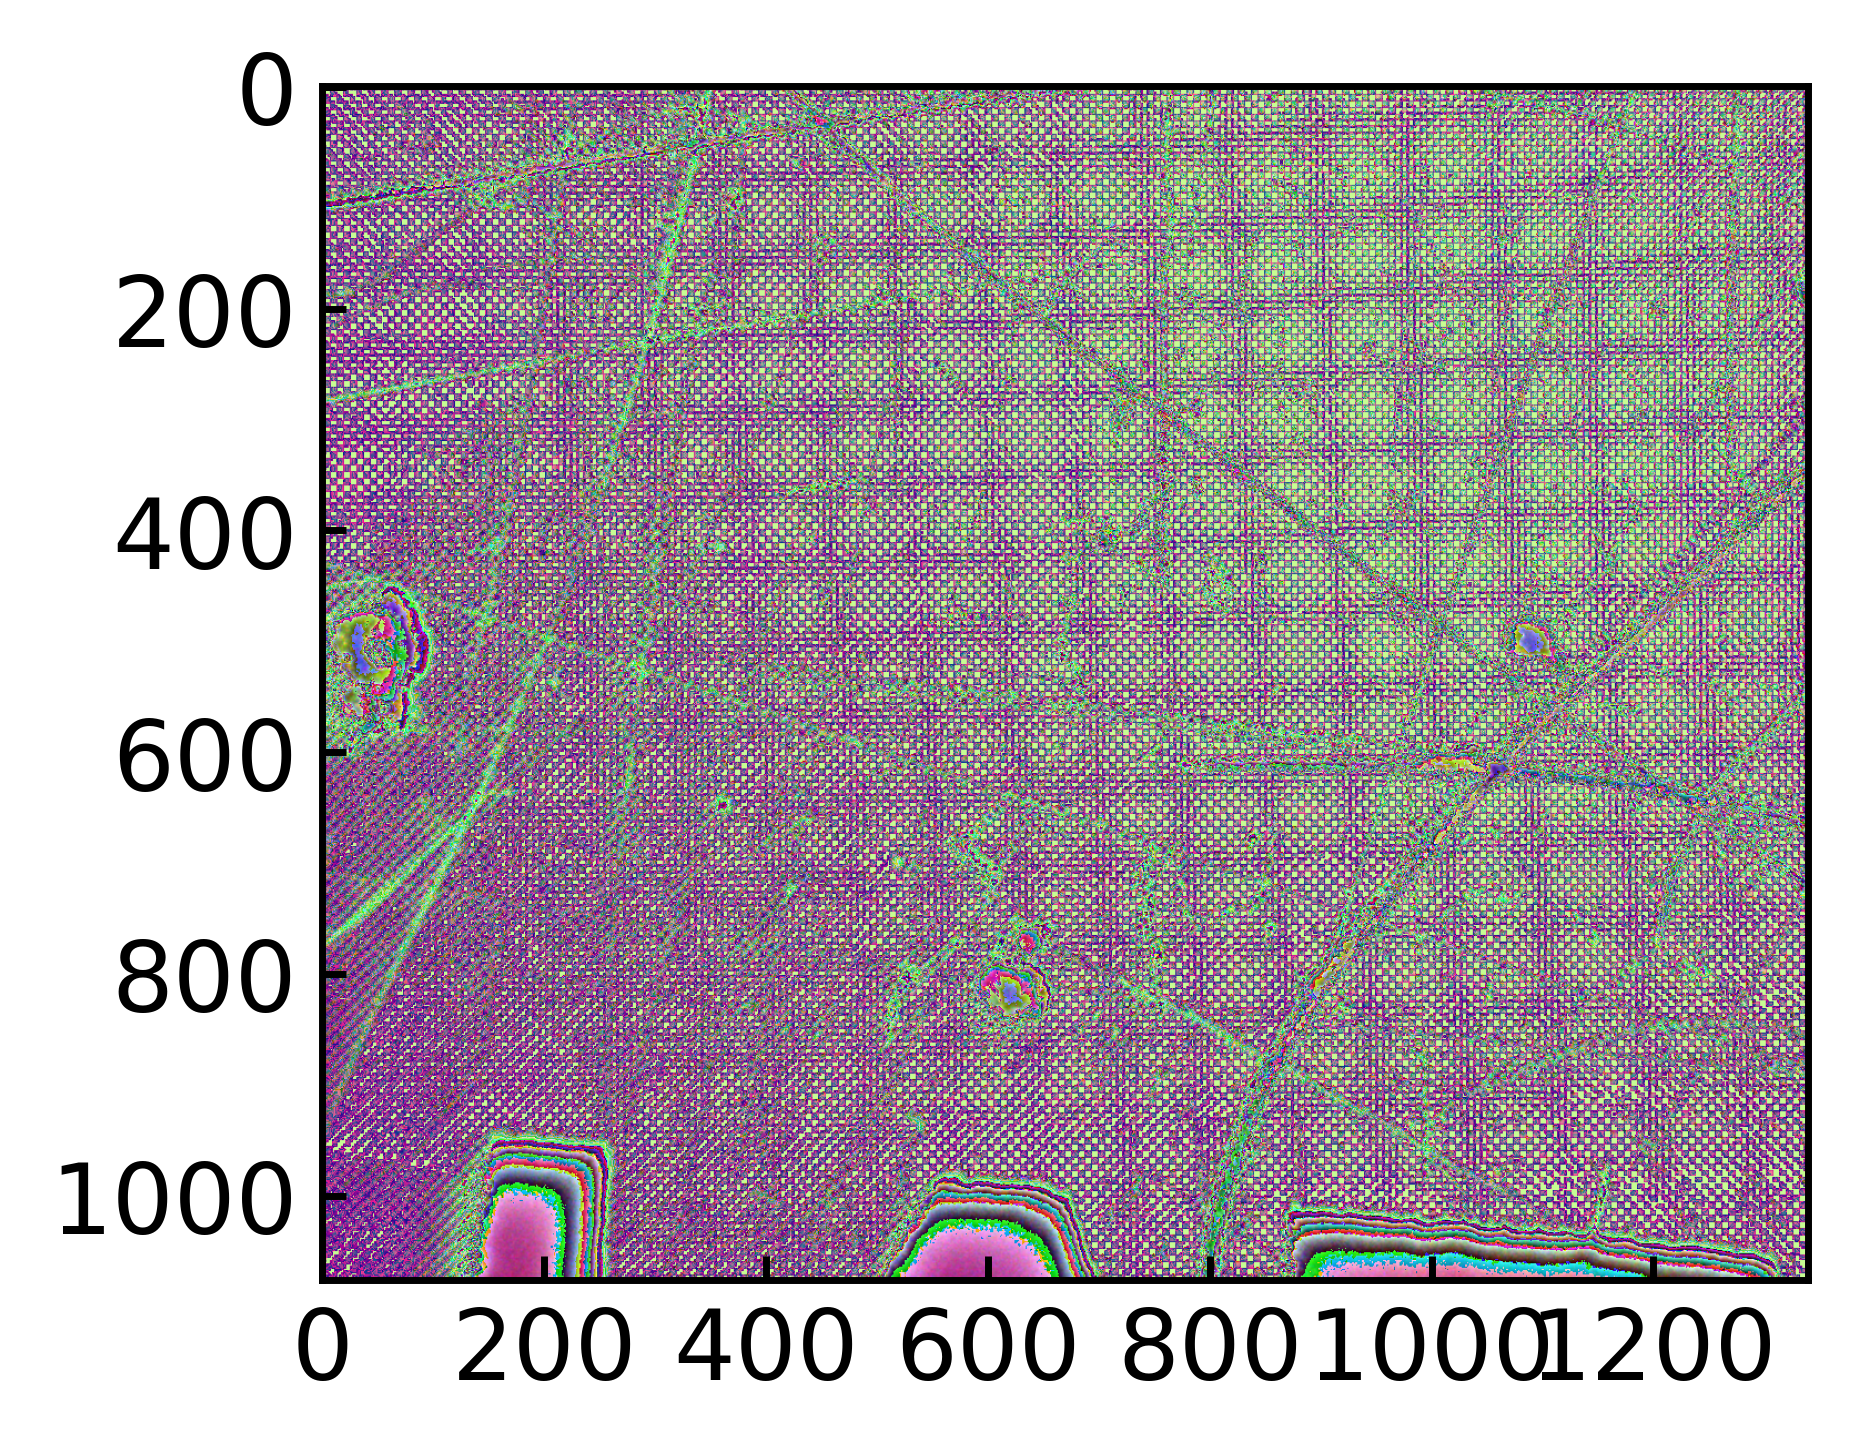

In [4]:
pixel_size=3.45 # um
with rc_context(fname=rc_fname):
    image = im.fromarray(np.uint8(dset_i_corr),mode="RGB")
    plt.imshow(image)

C:\ProgramData\Miniconda3\envs\lab\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


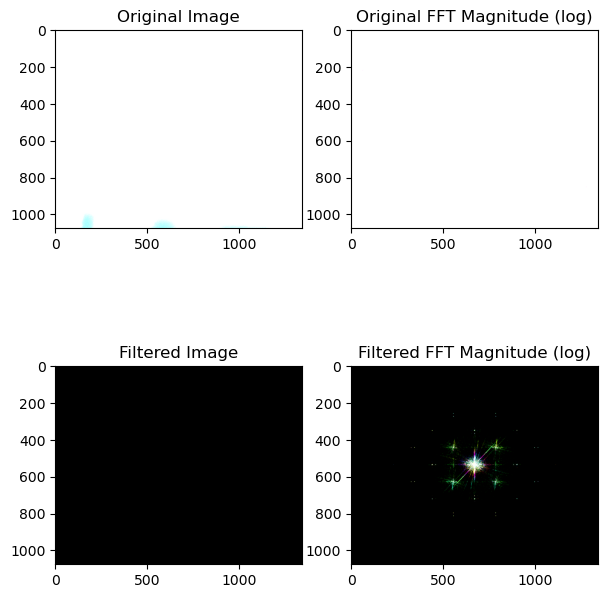

In [5]:
image = dset_i_corr
wimage = image * window('hann', image.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(image, 1, 2)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 8))
ax[0, 0].imshow(image, cmap='viridis')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='viridis')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

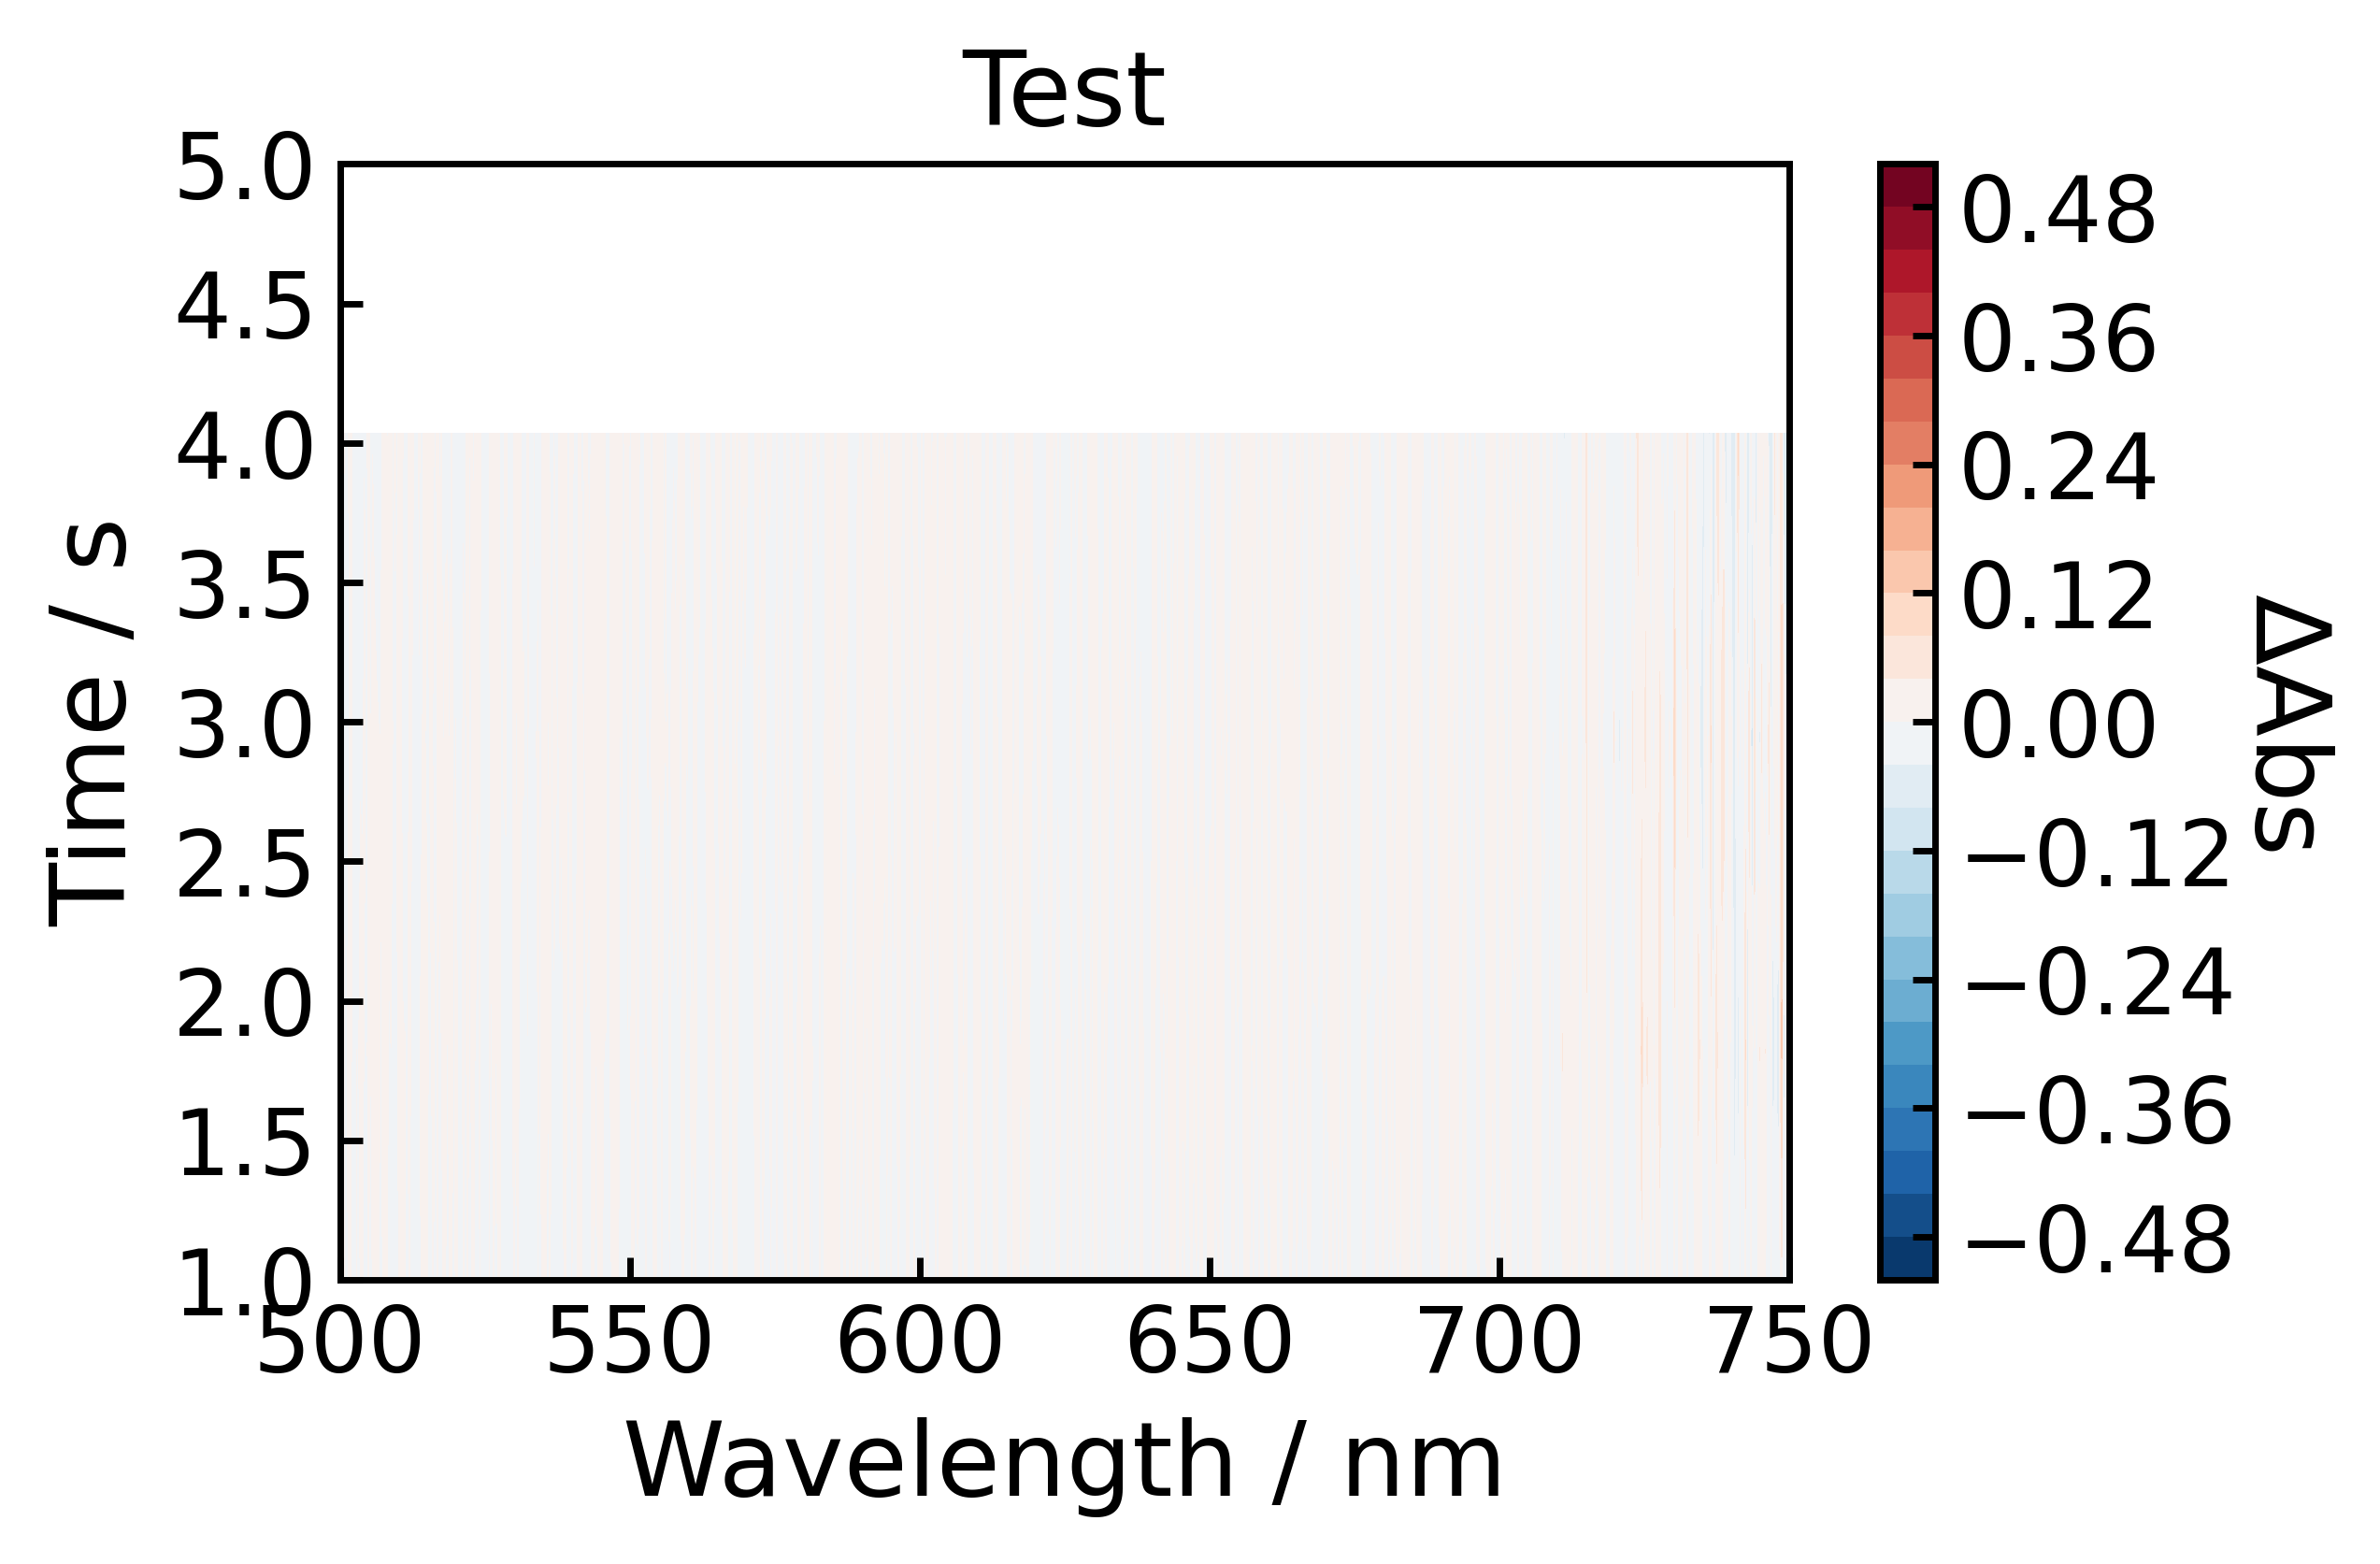

In [6]:
absMIN=-0.5
absMAX=0.5

y=spec_df.index
x=ref_s.index
z=spec_df

levels1 = MaxNLocator(nbins=25).tick_values(absMIN,absMAX)
OD_n=int(np.floor((((absMAX-0)/(absMAX-absMIN))*256)))
OD_p=256-OD_n
cm_t=cm.get_cmap('RdBu', OD_p)
cm_b=cm.get_cmap('RdBu', OD_n)
newcolors=np.vstack((cm_t(np.linspace(1, 0.5, OD_p)),cm_b(np.linspace(0.5, 0, OD_n))))
newcmp1=ListedColormap(newcolors, name='shifted_cmap')
    
with rc_context(fname=rc_fname):
    #cb=plt.pcolormesh(x,y,z,cmap= newcmp1,shading='gouraud',vmin=absMIN,vmax=absMAX)
    cb=plt.contourf(x,y,z,cmap=newcmp1,levels=levels1)
    cbar=plt.colorbar(cb)
    cbar.set_label('$\Delta$Abs', rotation=270,labelpad=15)
    plt.ylabel('Time / s')
    plt.xlabel('Wavelength / nm')
    plt.xlim(500,750)
    plt.ylim(1,5)
    plt.title('Test')

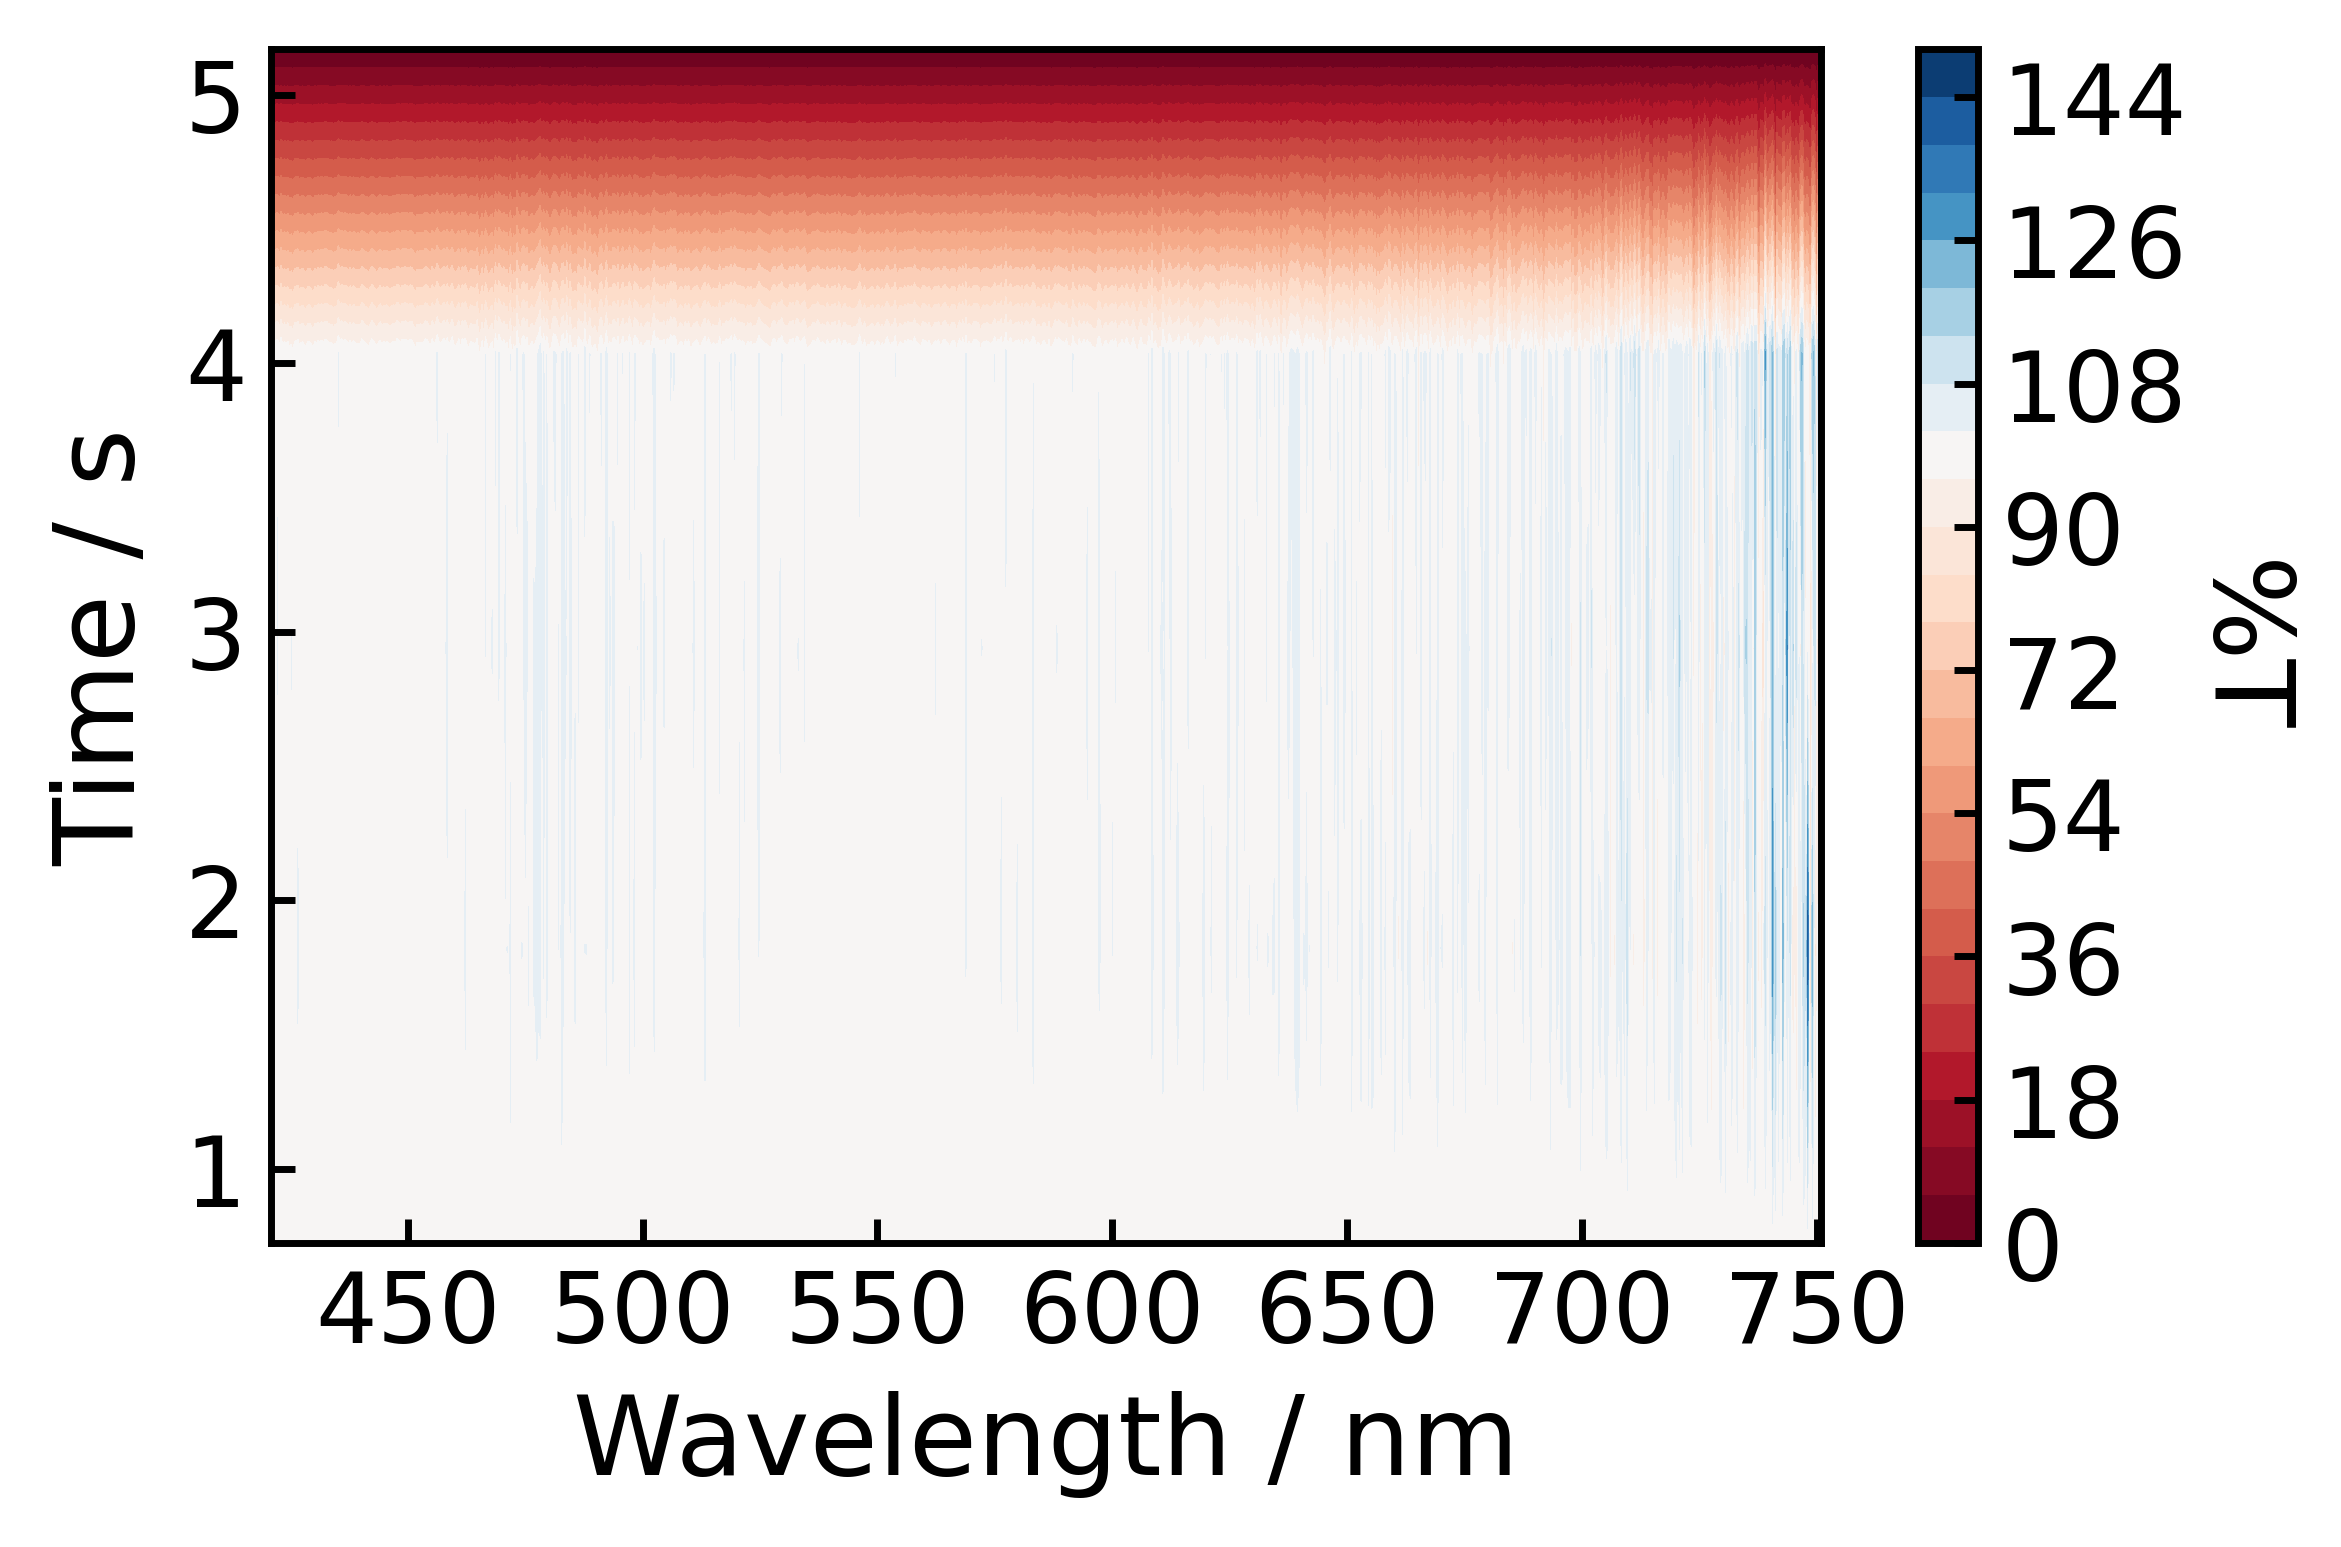

In [7]:
tMIN=0
tMAX=150

y=spec_df.index
x=ref_s.index
z=trans_df

levels2 = MaxNLocator(nbins=25).tick_values(tMIN,tMAX)
OD_n=int(np.floor((((tMAX-100)/(tMAX-tMIN))*256)))
OD_p=256-OD_n
cm_t=cm.get_cmap('RdBu', OD_p)
cm_b=cm.get_cmap('RdBu', OD_n)
newcolors=np.vstack((cm_t(np.linspace(0, 0.5, OD_p)),cm_b(np.linspace(0.5, 1, OD_n))))
newcmp2=ListedColormap(newcolors, name='shifted_cmap')

with rc_context(fname=rc_fname):
    #cb=plt.pcolormesh(x,y,z,cmap=newcmp2,shading='gouraud',vmin=tMIN,vmax=tMAX)
    cb=plt.contourf(x,y,z,cmap=newcmp2,levels=levels2)
    cbar=plt.colorbar(cb)
    cbar.set_label('%T', rotation=270,labelpad=15)
    plt.ylabel('Time / s')
    plt.xlabel('Wavelength / nm')

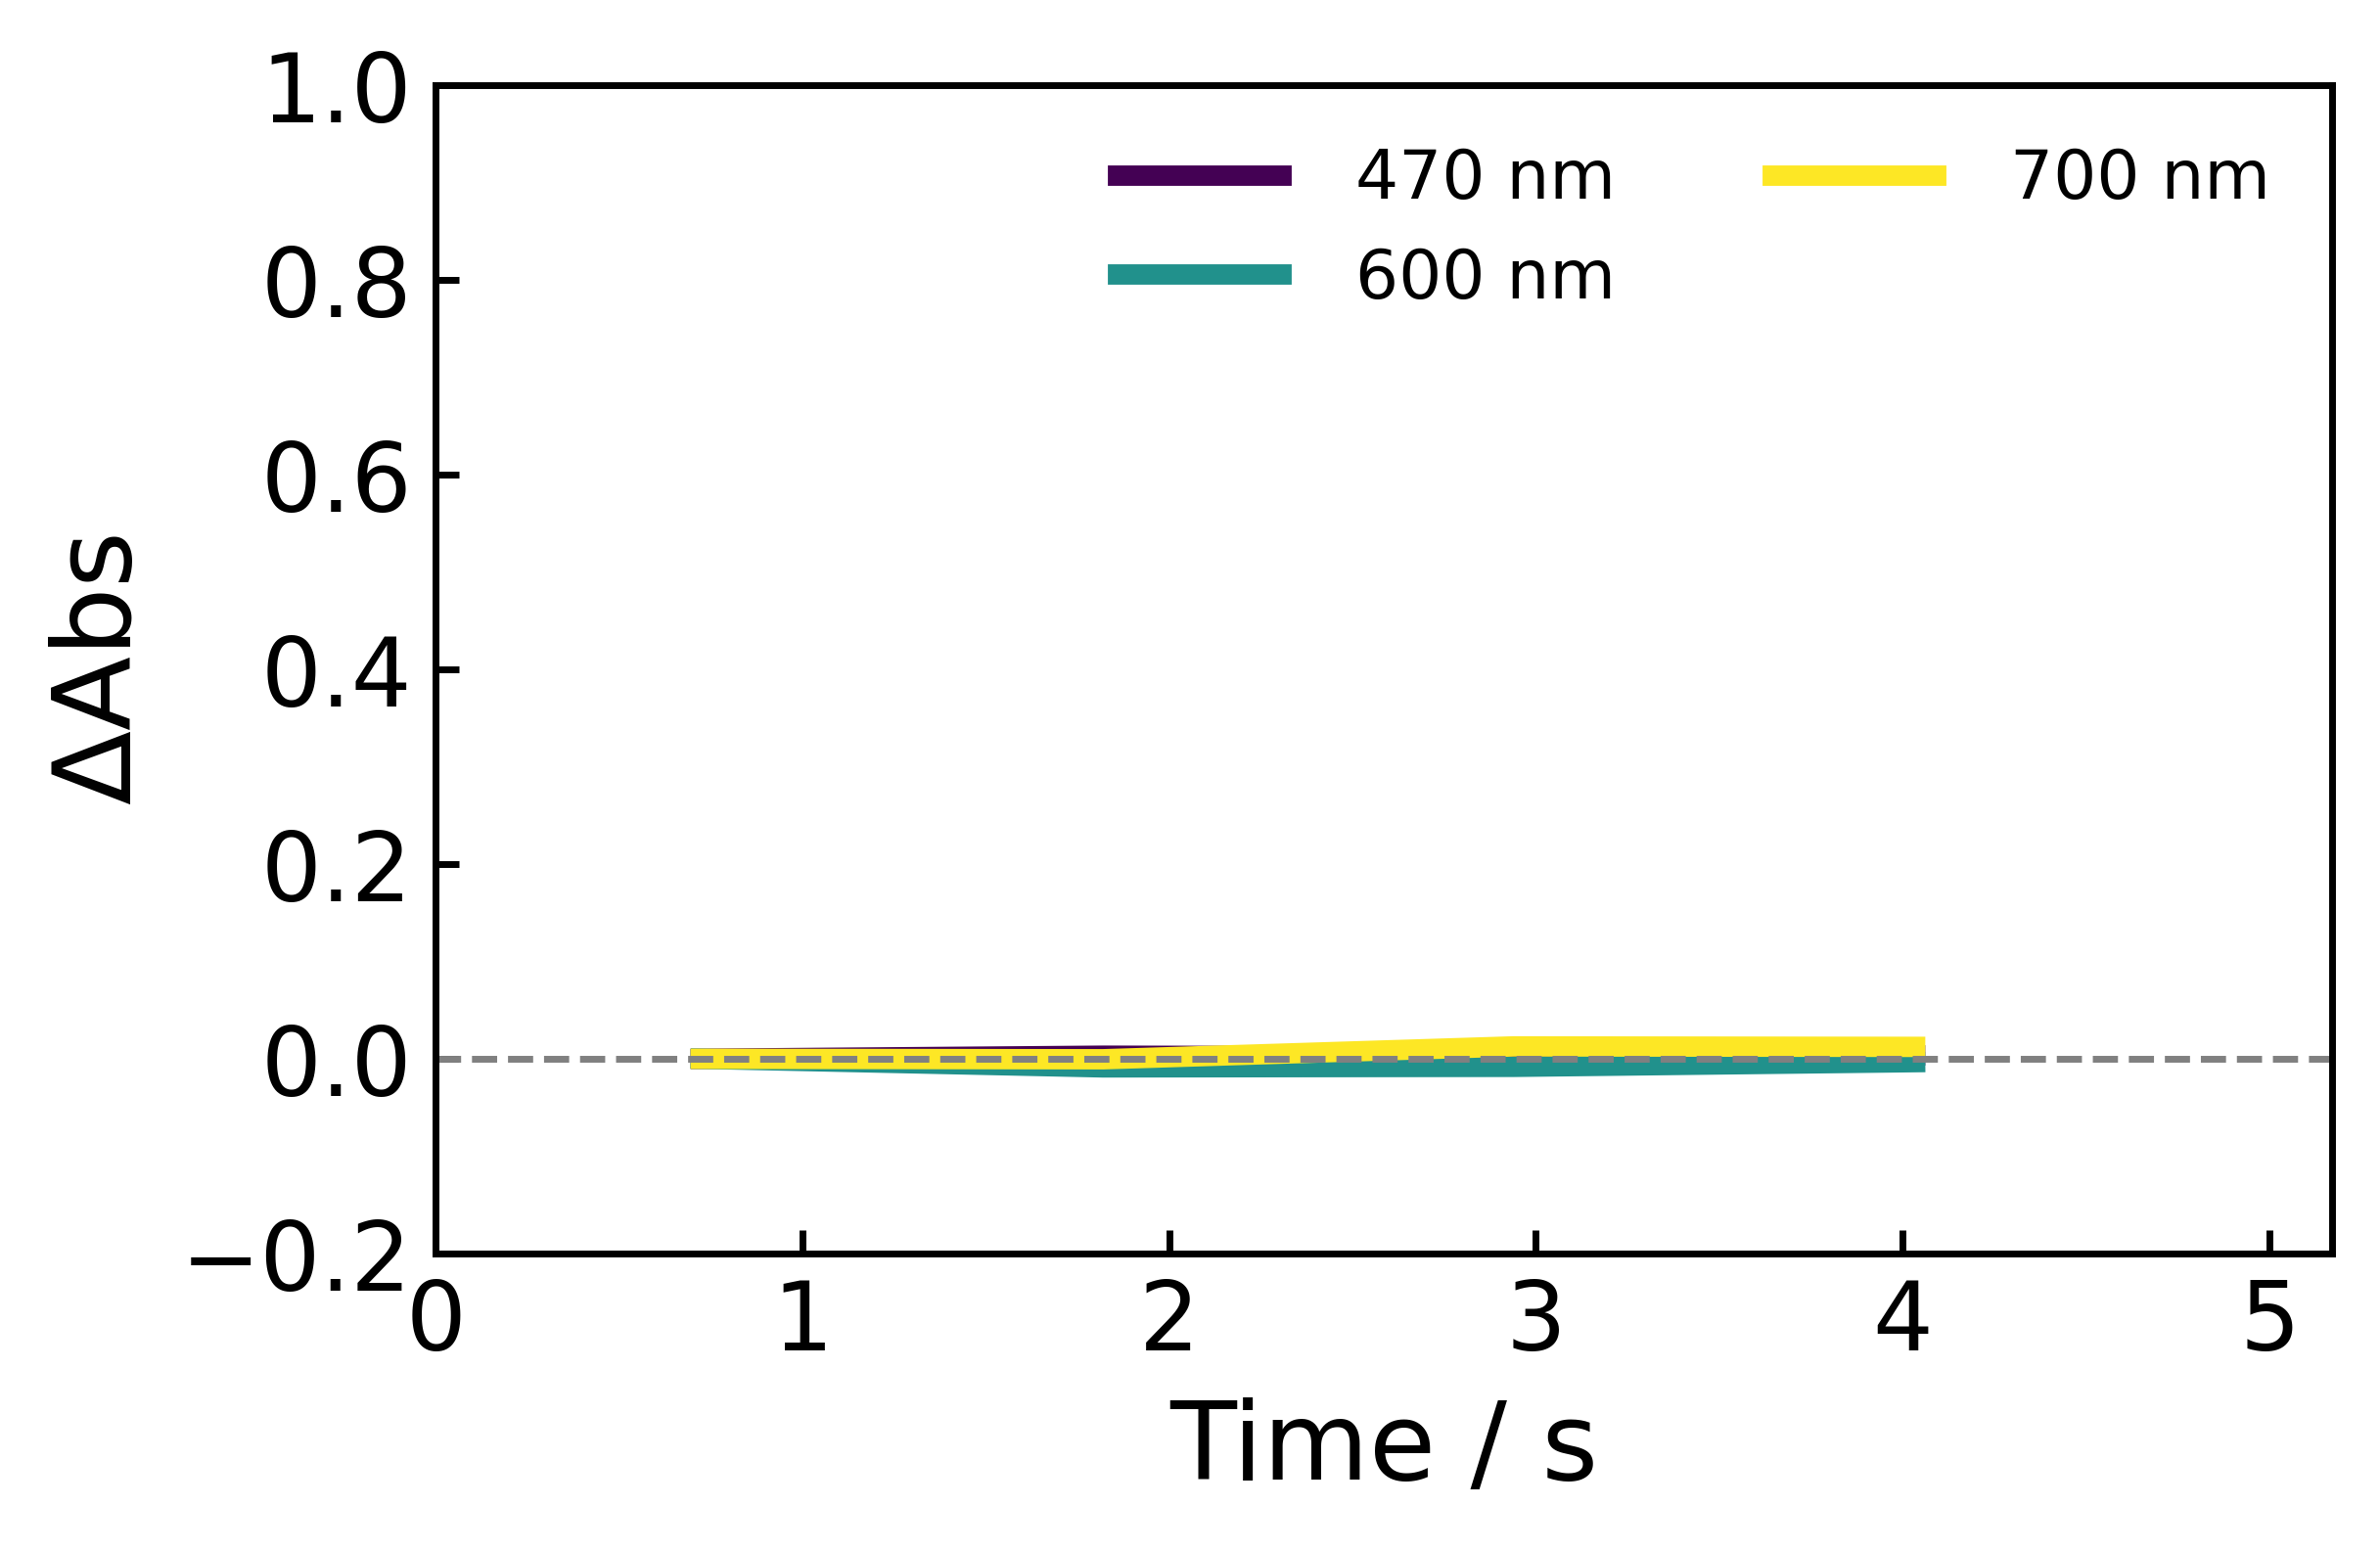

In [8]:
wav_select=[470,600,700]

evenly_spaced_interval = np.linspace(0, 1, len(wav_select))
colors = [cm.viridis(x) for x in evenly_spaced_interval]

wav_precise_select=[]
wav_slice_dict={}
for wav in wav_select:
    temp=find_nearest_val(ref_s.index,wav)
    wav_precise_select.append(temp)
    wav_slice=spec_df[temp]
    wav_slice_dict[temp]=wav_slice

with rc_context(fname=rc_fname):
    for counter, wav in enumerate(wav_slice_dict):
        plt.plot(wav_slice_dict[wav],lw=3,label=str(int(wav))+' nm',color=colors[counter])
    plt.ylabel('$\Delta$Abs')
    plt.xlabel('Time / s')
    plt.xlim(0,max(spec_df.index))
    plt.ylim(-0.2,1)
    plt.legend(ncol=2,fontsize=10)
    plt.axhline(0,ls='--',color='grey',lw=1)

In [9]:
SG_window=11
SG_order=3

with rc_context(fname=rc_fname):
    for counter, wav in enumerate(wav_slice_dict):
        delta_y=np.diff(wav_slice_dict[wav].values)
        delta_x=np.diff(wav_slice_dict[wav].index)
        dydx=np.divide(delta_y,delta_x)
        dydx[np.isnan(dydx)] = 0
        dydx_SG=savgol_filter(dydx,SG_window,SG_order)
        plt.plot(wav_slice_dict[wav].index[1:],dydx_SG,lw=3,label=str(int(wav))+' nm',color=colors[counter])
    plt.ylabel('d[Abs]/dT / s$^{-1}$')
    plt.xlabel('Time / s')
    plt.xlim(0,max(spec_df.index))
    plt.ylim(-0.005,0.01)
    plt.legend(fontsize=10,frameon=True)
    plt.axhline(0,ls='--',color='grey',lw=1)

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [ ]:
time_select=[50,100,200,300,400,500,600]

evenly_spaced_interval = np.linspace(0, 1, len(time_select))
colors = [cm.viridis(x) for x in evenly_spaced_interval]

time_precise_select=[]
time_slice_dict={}
for time in time_select:
    temp=find_nearest_val(spec_df.index,time)
    time_precise_select.append(temp)
    time_slice=spec_df.loc[temp]
    time_slice_dict[temp]=time_slice

with rc_context(fname=rc_fname):
    for counter, time in enumerate(time_slice_dict):
        plt.plot(time_slice_dict[time],lw=3,label=str(int(time))+' s',color=colors[counter])
    plt.ylabel('$\Delta$Abs')
    plt.xlabel('Wavelength / nm')
    plt.xlim(420,750)
    plt.ylim(-0.2,1.2)
    plt.legend(ncol=3,fontsize=10)
    plt.axhline(0,ls='--',color='grey',lw=1)

In [10]:
f.close()